In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from  matplotlib.colors import LinearSegmentedColormap
import pandas as pd
import seaborn as sn
import sys
import os
from pathlib import Path
from tqdm import tqdm
from timeit import default_timer as timer
from datetime import timedelta

import torch.nn as nn
from torch import Tensor
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.optim as optim
from torchmetrics.classification import BinaryCalibrationError
from sklearn.metrics import log_loss as log_loss

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.calibration import CalibrationDisplay
from sklearn.calibration import calibration_curve

# import custom functions from src folder
module_path = str(Path.cwd() / "../../../src")

if module_path not in sys.path:
    sys.path.append(module_path)

from SequentialNet import SequentialNet
from machine_learning import *
from evidential import *
from util import *


In [2]:
sn.set_palette("tab10")
sn.color_palette()

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

In [3]:
def label_maker(values, num_classes):
    labels = np.zeros((len(values), num_classes))
    for i, value in enumerate(values):
        labels[i][value] = 1
    return torch.Tensor(labels).to(torch.int)

In [4]:
# Set up device
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device {torch.cuda.get_device_name(1)}")

Using cuda device NVIDIA GeForce GTX 1080 Ti


In [5]:
# Machine learning options
x1_key = "x1"
x2_key = "x2"
n_data = [250, 500, 1000, 2000, 3000, 5000, 10000]
bs_list = [128, 128, 128*2, 128*2, 1024, 1024, 1024*2]
#n_data = [10000]
max_err_val = [0]*len(n_data)
for i in range(len(n_data)):
    if n_data[i] < 1000:
        max_err_val[i] = 0.5
    else:
        max_err_val[i] = 0.25
patience = 30
load_values = False
save_values = True

#Data constants
shapes = [2, 6]
scales = [5, 3]
k = len(scales) # Number of classes
d = 2 # Number of dimensions
p_c = [1/len(shapes)]*len(shapes) # Uniform distributon over classes

tag = f'k_{k}_d{d}_shapes{shapes}_scales{scales}_pc{p_c}'.replace(" ", "")


# Read files
train_n = 50000
trainfile = f"train_n_{train_n}_{tag}"
valfile = f"val_n_5000_{tag}"
testfile = f"test_n_10000_{tag}"
gridfile = f"grid_x1_x2_10000_{tag}"
large_gridfile = f"grid_r_a1_2500_{tag}"

train_data = pd.read_csv(f"../data/{trainfile}.csv")
val_data = pd.read_csv(f"../data/{valfile}.csv")
test_data = pd.read_csv(f"../data/{testfile}.csv")
grid_data = pd.read_csv(f"../data/{gridfile}.csv")
large_grid_data = pd.read_csv(f"../data/{large_gridfile}.csv")
grid_rmax = grid_data["x1"].max()
large_grid_rmax = large_grid_data["r"].max()

# Max accuracy on test set
max_acc = np.sum(train_data[[f"p_c{i}_given_r" for i in range(k)]].max(axis=1))/len(train_data)
print("Max acc train data: ", max_acc)
max_acc = np.sum(test_data[[f"p_c{i}_given_r" for i in range(k)]].max(axis=1))/len(test_data)
print("Max acc test data: ", max_acc)

X_train = torch.Tensor(np.dstack((train_data[x1_key], train_data[x2_key]))).to(torch.float32)[0]
Y_train = label_maker(train_data["class"], 2)

X_val = torch.Tensor(np.dstack((val_data[x1_key], val_data[x2_key]))).to(torch.float32)[0]
Y_val = label_maker(val_data["class"], 2)

X_test = torch.Tensor(np.dstack((test_data[x1_key], test_data[x2_key]))).to(torch.float32)[0]
Y_test = label_maker(test_data["class"], 2)

X_grid = torch.Tensor(np.dstack((grid_data[x1_key], grid_data[x2_key]))).to(torch.float32)[0]
Y_grid = torch.zeros(X_grid.shape)

X_large_grid = torch.Tensor(np.dstack((large_grid_data[x1_key], large_grid_data[x2_key]))).to(torch.float32)[0]
Y_large_grid = torch.zeros(X_large_grid.shape)

Max acc train data:  0.7405497427147698
Max acc test data:  0.7385207198110306


In [6]:
# Create datasets for pytorch
val_dataset = torch.utils.data.TensorDataset(X_val, Y_val)
test_dataset = torch.utils.data.TensorDataset(X_test, Y_test)
grid_dataset = torch.utils.data.TensorDataset(X_grid, Y_grid)
large_grid_dataset = torch.utils.data.TensorDataset(X_large_grid, Y_large_grid)

In [7]:
epochs = 100 #Affects annealation coefficient
lr = 0.001
annealing_coef = 0.2

test_dfs = [0]*len(n_data)
grid_dfs = [0]*len(n_data)
large_grid_dfs = [0]*len(n_data)

for i in range(len(n_data)):
    if load_values == False:
        logloss_min = 1
        test_dfs[i] = pd.read_csv(f"../data/{testfile}.csv")
        grid_dfs[i] = pd.read_csv(f"../data/{gridfile}.csv")
        large_grid_dfs[i] = pd.read_csv(f"../data/{large_gridfile}.csv")
        for j in tqdm(range(5)):
            val_df = pd.read_csv(f"../data/{valfile}.csv")
            n_train = n_data[i]
            batchsize = bs_list[i]

            model = SequentialNet(L=200, n_hidden=3, activation="relu", in_channels=2, out_channels=2).to(device)

            optimizer = optim.Adam(model.parameters(), lr=lr)
            train_dataset = torch.utils.data.TensorDataset(X_train[0:n_train], Y_train[0:n_train])
            training_results = train_evidential_classifier(model, train_dataset, 
                                    val_dataset, batchsize=batchsize, epochs = epochs, 
                                    device = device, optimizer = optimizer, annealing_coef=annealing_coef, 
                                    early_stopping=patience)
            
            probs_val, uncertainties_val, beliefs_val = predict_evidential_classifier(model, val_dataset, 2, 100, device)
            preds_val = torch.argmax(probs_val, dim=-1).flatten()
            val_df["Prediction"] = preds_val
            val_df["Est_prob_blue"] = probs_val[:,1] #Get probability score for blue

            ll = log_loss(val_df["class"], val_df["Est_prob_blue"])
            preds = torch.Tensor(val_df["Est_prob_blue"])
            target = torch.Tensor(val_df["class"])
            bce_l1 = BinaryCalibrationError(n_bins=15, norm='l1')
            ece = bce_l1(preds, target).item()
            print(f"n_train = {n_data[i]}, logloss={ll}, ECE= {ece}, best value: {logloss_min}")

            if ll < logloss_min:
                print(f"New best values: n_train = {n_data[i]}, logloss={ll}, ECE= {ece}")
                logloss_min = ll

                probs_test, uncertainties_test, beliefs_test = predict_evidential_classifier(model, test_dataset, 2, 100, device)
                preds_test = torch.argmax(probs_test, dim=-1).flatten()
                test_dfs[i]["Prediction"] = preds_test
                test_dfs[i]["Est_prob_blue"] = probs_test[:,1] #Get probability score for blue
                test_dfs[i]["Uncertainty"] = uncertainties_test[:,1]
                test_dfs[i]["Std_prob_blue"] = uncertainties_test[:,1]/2
                test_dfs[i]["Beliefs"] = beliefs_test[:,1]

                probs_grid, uncertainties_grid, beliefs_grid = predict_evidential_classifier(model, grid_dataset, 2, 100, device)
                preds_grid = torch.argmax(probs_grid, dim=-1).flatten()
                grid_dfs[i]["Prediction"] = preds_grid
                grid_dfs[i]["Est_prob_blue"] = probs_grid[:,1] #Get probability score for blue
                grid_dfs[i]["Uncertainty"] = uncertainties_grid[:,1]
                grid_dfs[i]["Std_prob_blue"] = uncertainties_grid[:,1]/2
                grid_dfs[i]["Beliefs"] = beliefs_grid[:,1]

                probs_large_grid, uncertainties_large_grid, beliefs_large_grid = predict_evidential_classifier(model, large_grid_dataset, 2, 100, device)
                preds_large_grid = torch.argmax(probs_large_grid, dim=-1).flatten()
                large_grid_dfs[i]["Prediction"] = preds_large_grid
                large_grid_dfs[i]["Est_prob_blue"] = probs_large_grid[:,1] #Get probability score for blue
                large_grid_dfs[i]["Uncertainty"] = uncertainties_large_grid[:,1]
                large_grid_dfs[i]["Std_prob_blue"] = uncertainties_large_grid[:,1]/2
                large_grid_dfs[i]["Beliefs"] = beliefs_large_grid[:,1]

        # Save prediction
        if save_values:
            if (not os.path.isdir(f"predictions/{trainfile}") ):
                os.mkdir(f"predictions/{trainfile}")
            test_dfs[i].to_csv(f"predictions/{trainfile}/evidential/{testfile}_SequentialNet_evidential_best_ndata-{n_data[i]}.csv")
            grid_dfs[i].to_csv(f"predictions/{trainfile}/evidential/grid_{tag}_SequentialNet_evidential_best_ndata-{n_data[i]}.csv")
            large_grid_dfs[i].to_csv(f"predictions/{trainfile}/evidential/large_grid_{tag}_SequentialNet_evidential_best_ndata-{n_data[i]}.csv")
    else:
        test_dfs[i] = pd.read_csv(f"predictions/{trainfile}/evidential/{testfile}_SequentialNet_evidential_best_ndata-{n_data[i]}.csv")
        grid_dfs[i] = pd.read_csv(f"predictions/{trainfile}/evidential/grid_{tag}_SequentialNet_evidential_best_ndata-{n_data[i]}.csv")
        large_grid_dfs[i] = pd.read_csv(f"predictions/{trainfile}/evidential/large_grid_{tag}_SequentialNet_evidential_best_ndata-{n_data[i]}.csv")

  0%|          | 0/5 [00:00<?, ?it/s]

 54%|█████▍    | 54/100 [00:04<00:03, 12.48it/s]


Stopping training early at epoch 54


100%|██████████| 50/50 [00:00<00:00, 438.35it/s]


n_train = 250, logloss=0.5587576167034265, ECE= 0.06339103728532791, best value: 1
New best values: n_train = 250, logloss=0.5587576167034265, ECE= 0.06339103728532791


 69%|██████▉   | 69/100 [00:04<00:02, 13.86it/s]


Stopping training early at epoch 69


 40%|████      | 2/5 [00:12<00:17,  5.96s/it]

n_train = 250, logloss=0.6103466687103725, ECE= 0.10393449664115906, best value: 0.5587576167034265


 54%|█████▍    | 54/100 [00:03<00:03, 13.81it/s]


Stopping training early at epoch 54


 60%|██████    | 3/5 [00:16<00:10,  5.09s/it]

n_train = 250, logloss=0.5708457489090413, ECE= 0.0762462243437767, best value: 0.5587576167034265


 84%|████████▍ | 84/100 [00:06<00:01, 13.81it/s]


Stopping training early at epoch 84


 80%|████████  | 4/5 [00:22<00:05,  5.54s/it]

n_train = 250, logloss=0.579985243143211, ECE= 0.051443830132484436, best value: 0.5587576167034265


 69%|██████▉   | 69/100 [00:04<00:02, 13.86it/s]


Stopping training early at epoch 69


100%|██████████| 5/5 [00:27<00:00,  5.54s/it]

n_train = 250, logloss=0.6040982686772828, ECE= 0.11957308650016785, best value: 0.5587576167034265



 59%|█████▉    | 59/100 [00:08<00:05,  6.90it/s]


Stopping training early at epoch 59


100%|██████████| 50/50 [00:00<00:00, 455.99it/s]


n_train = 500, logloss=0.5522905259578844, ECE= 0.056460194289684296, best value: 1
New best values: n_train = 500, logloss=0.5522905259578844, ECE= 0.056460194289684296


 54%|█████▍    | 54/100 [00:07<00:06,  6.91it/s]


Stopping training early at epoch 54


 40%|████      | 2/5 [00:17<00:25,  8.48s/it]

n_train = 500, logloss=0.6511921661531309, ECE= 0.07545816898345947, best value: 0.5522905259578844


 52%|█████▏    | 52/100 [00:07<00:06,  6.86it/s]


Stopping training early at epoch 52


 60%|██████    | 3/5 [00:24<00:16,  8.13s/it]

n_train = 500, logloss=0.6767220885407154, ECE= 0.12048729509115219, best value: 0.5522905259578844


 47%|████▋     | 47/100 [00:06<00:07,  6.89it/s]


Stopping training early at epoch 47


 80%|████████  | 4/5 [00:31<00:07,  7.67s/it]

n_train = 500, logloss=0.6064857835176597, ECE= 0.07009454816579819, best value: 0.5522905259578844


 52%|█████▏    | 52/100 [00:07<00:06,  6.91it/s]


Stopping training early at epoch 52


100%|██████████| 5/5 [00:39<00:00,  7.91s/it]

n_train = 500, logloss=0.7030872499047786, ECE= 0.05713990330696106, best value: 0.5522905259578844



 49%|████▉     | 49/100 [00:12<00:13,  3.77it/s]


Stopping training early at epoch 49


100%|██████████| 50/50 [00:00<00:00, 452.23it/s]


n_train = 1000, logloss=0.6060951973868854, ECE= 0.08993080258369446, best value: 1
New best values: n_train = 1000, logloss=0.6060951973868854, ECE= 0.08993080258369446


 67%|██████▋   | 67/100 [00:17<00:08,  3.76it/s]


Stopping training early at epoch 67


100%|██████████| 50/50 [00:00<00:00, 442.98it/s]


n_train = 1000, logloss=0.5450495887075858, ECE= 0.046310849487781525, best value: 0.6060951973868854
New best values: n_train = 1000, logloss=0.5450495887075858, ECE= 0.046310849487781525


 47%|████▋     | 47/100 [00:12<00:14,  3.75it/s]


Stopping training early at epoch 47


 60%|██████    | 3/5 [00:44<00:29, 14.74s/it]

n_train = 1000, logloss=0.5454605240649093, ECE= 0.040575720369815826, best value: 0.5450495887075858


 59%|█████▉    | 59/100 [00:15<00:10,  3.77it/s]


Stopping training early at epoch 59


 80%|████████  | 4/5 [01:00<00:15, 15.16s/it]

n_train = 1000, logloss=0.5860323849256414, ECE= 0.11567139625549316, best value: 0.5450495887075858


 72%|███████▏  | 72/100 [00:19<00:07,  3.76it/s]


Stopping training early at epoch 72


100%|██████████| 5/5 [01:19<00:00, 15.98s/it]

n_train = 1000, logloss=0.5483425127634795, ECE= 0.0389154888689518, best value: 0.5450495887075858



 58%|█████▊    | 58/100 [00:30<00:21,  1.93it/s]


Stopping training early at epoch 58


100%|██████████| 50/50 [00:00<00:00, 455.51it/s]


n_train = 2000, logloss=0.536315800570573, ECE= 0.0325159952044487, best value: 1
New best values: n_train = 2000, logloss=0.536315800570573, ECE= 0.0325159952044487


 56%|█████▌    | 56/100 [00:27<00:21,  2.07it/s]


Stopping training early at epoch 56


 40%|████      | 2/5 [00:57<01:26, 28.67s/it]

n_train = 2000, logloss=0.5653267138206335, ECE= 0.08107118308544159, best value: 0.536315800570573


 38%|███▊      | 38/100 [00:18<00:30,  2.06it/s]


Stopping training early at epoch 38


 60%|██████    | 3/5 [01:16<00:48, 24.07s/it]

n_train = 2000, logloss=0.6382071344338157, ECE= 0.0821206271648407, best value: 0.536315800570573


 51%|█████     | 51/100 [00:24<00:23,  2.06it/s]


Stopping training early at epoch 51


 80%|████████  | 4/5 [01:41<00:24, 24.38s/it]

n_train = 2000, logloss=0.5467214805950024, ECE= 0.043838199228048325, best value: 0.536315800570573


 37%|███▋      | 37/100 [00:18<00:30,  2.05it/s]


Stopping training early at epoch 37


100%|██████████| 5/5 [01:59<00:00, 23.92s/it]

n_train = 2000, logloss=0.5473745649330267, ECE= 0.040157515555620193, best value: 0.536315800570573



 43%|████▎     | 43/100 [00:28<00:37,  1.50it/s]


Stopping training early at epoch 43


100%|██████████| 50/50 [00:00<00:00, 438.46it/s]


n_train = 3000, logloss=0.6075654580399474, ECE= 0.07547105848789215, best value: 1
New best values: n_train = 3000, logloss=0.6075654580399474, ECE= 0.07547105848789215


 39%|███▉      | 39/100 [00:26<00:40,  1.49it/s]


Stopping training early at epoch 39


 40%|████      | 2/5 [00:55<01:22, 27.49s/it]

n_train = 3000, logloss=0.6730983245645132, ECE= 0.11430566012859344, best value: 0.6075654580399474


 69%|██████▉   | 69/100 [00:45<00:20,  1.51it/s]


Stopping training early at epoch 69


100%|██████████| 50/50 [00:00<00:00, 453.83it/s]


n_train = 3000, logloss=0.5414613499144111, ECE= 0.044949013739824295, best value: 0.6075654580399474
New best values: n_train = 3000, logloss=0.5414613499144111, ECE= 0.044949013739824295


 53%|█████▎    | 53/100 [00:35<00:31,  1.51it/s]


Stopping training early at epoch 53


 80%|████████  | 4/5 [02:17<00:35, 35.75s/it]

n_train = 3000, logloss=0.7399648073751599, ECE= 0.08292269706726074, best value: 0.5414613499144111


 56%|█████▌    | 56/100 [00:37<00:29,  1.51it/s]


Stopping training early at epoch 56


100%|██████████| 5/5 [02:54<00:00, 34.85s/it]

n_train = 3000, logloss=0.6638027699809683, ECE= 0.09193502366542816, best value: 0.5414613499144111



 61%|██████    | 61/100 [01:07<00:43,  1.10s/it]


Stopping training early at epoch 61


100%|██████████| 50/50 [00:00<00:00, 459.61it/s]


n_train = 5000, logloss=0.5375170647609986, ECE= 0.039333924651145935, best value: 1
New best values: n_train = 5000, logloss=0.5375170647609986, ECE= 0.039333924651145935


 57%|█████▋    | 57/100 [01:02<00:46,  1.09s/it]


Stopping training early at epoch 57


 40%|████      | 2/5 [02:10<03:13, 64.58s/it]

n_train = 5000, logloss=0.5403922118794179, ECE= 0.03803757578134537, best value: 0.5375170647609986


 61%|██████    | 61/100 [01:06<00:42,  1.09s/it]


Stopping training early at epoch 61


100%|██████████| 50/50 [00:00<00:00, 460.80it/s]


n_train = 5000, logloss=0.5308079141591989, ECE= 0.03021470457315445, best value: 0.5375170647609986
New best values: n_train = 5000, logloss=0.5308079141591989, ECE= 0.03021470457315445


 41%|████      | 41/100 [00:45<01:05,  1.10s/it]


Stopping training early at epoch 41


 80%|████████  | 4/5 [04:02<00:57, 57.70s/it]

n_train = 5000, logloss=0.5320810734018936, ECE= 0.030159976333379745, best value: 0.5308079141591989


 39%|███▉      | 39/100 [00:42<01:06,  1.10s/it]


Stopping training early at epoch 39


100%|██████████| 5/5 [04:45<00:00, 57.14s/it]

n_train = 5000, logloss=0.5841760909970982, ECE= 0.09122606366872787, best value: 0.5308079141591989



 35%|███▌      | 35/100 [01:24<02:37,  2.42s/it]


Stopping training early at epoch 35


100%|██████████| 50/50 [00:00<00:00, 454.36it/s]


n_train = 10000, logloss=0.6989794914115277, ECE= 0.10441221296787262, best value: 1
New best values: n_train = 10000, logloss=0.6989794914115277, ECE= 0.10441221296787262


 37%|███▋      | 37/100 [01:29<02:31,  2.41s/it]


Stopping training early at epoch 37


100%|██████████| 50/50 [00:00<00:00, 441.10it/s]


n_train = 10000, logloss=0.6007552896726802, ECE= 0.07150417566299438, best value: 0.6989794914115277
New best values: n_train = 10000, logloss=0.6007552896726802, ECE= 0.07150417566299438


 59%|█████▉    | 59/100 [02:22<01:39,  2.42s/it]


Stopping training early at epoch 59


100%|██████████| 50/50 [00:00<00:00, 457.06it/s]


n_train = 10000, logloss=0.5639838190783134, ECE= 0.08591439574956894, best value: 0.6007552896726802
New best values: n_train = 10000, logloss=0.5639838190783134, ECE= 0.08591439574956894


 55%|█████▌    | 55/100 [02:13<01:48,  2.42s/it]


Stopping training early at epoch 55


100%|██████████| 50/50 [00:00<00:00, 458.73it/s]


n_train = 10000, logloss=0.5468578054471073, ECE= 0.05193160101771355, best value: 0.5639838190783134
New best values: n_train = 10000, logloss=0.5468578054471073, ECE= 0.05193160101771355


 37%|███▋      | 37/100 [01:30<02:34,  2.45s/it]


Stopping training early at epoch 37


100%|██████████| 50/50 [00:00<00:00, 442.16it/s]


n_train = 10000, logloss=0.536254831972518, ECE= 0.05064985901117325, best value: 0.5468578054471073
New best values: n_train = 10000, logloss=0.536254831972518, ECE= 0.05064985901117325


100%|██████████| 5/5 [09:03<00:00, 108.64s/it]


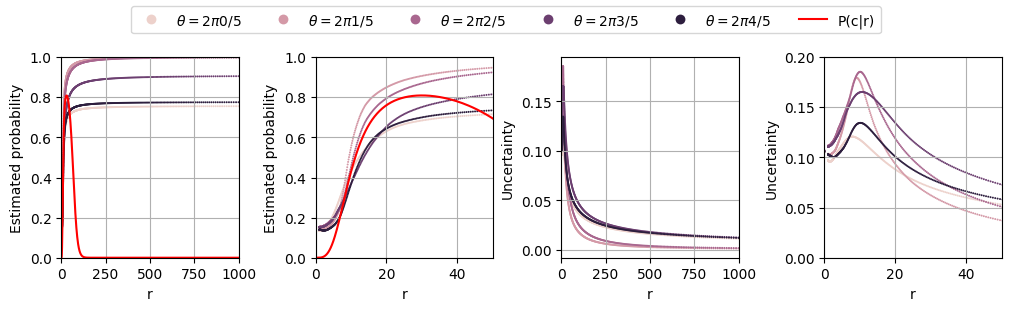

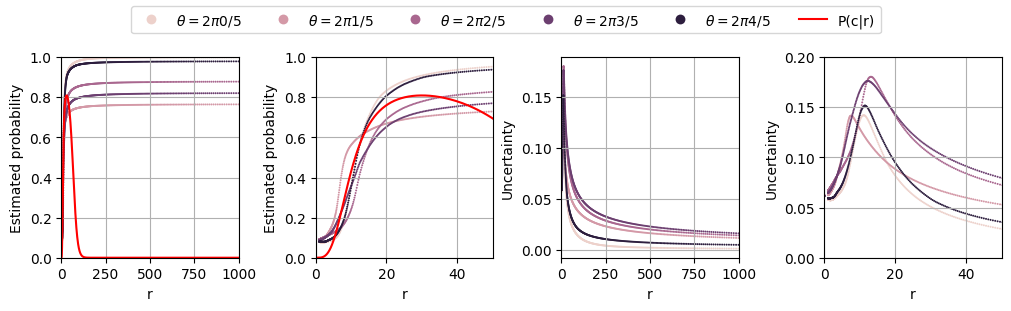

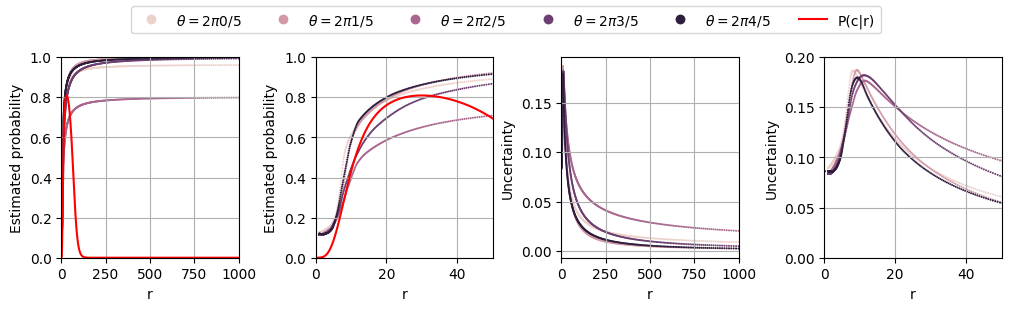

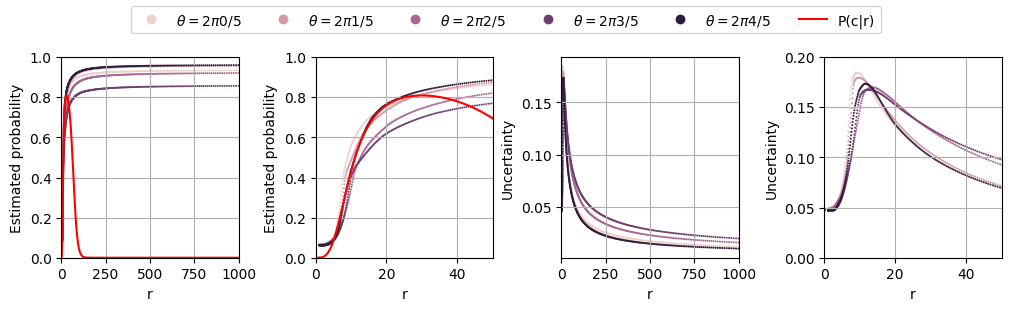

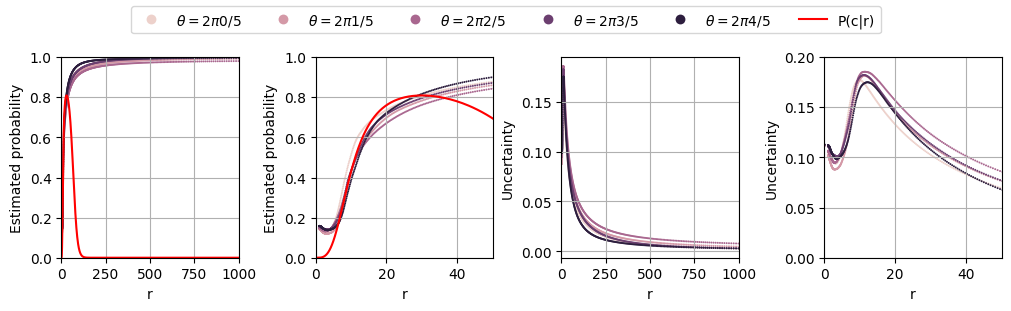

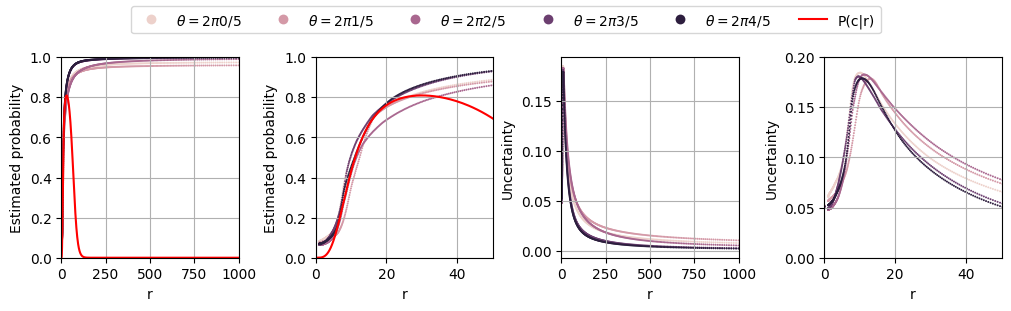

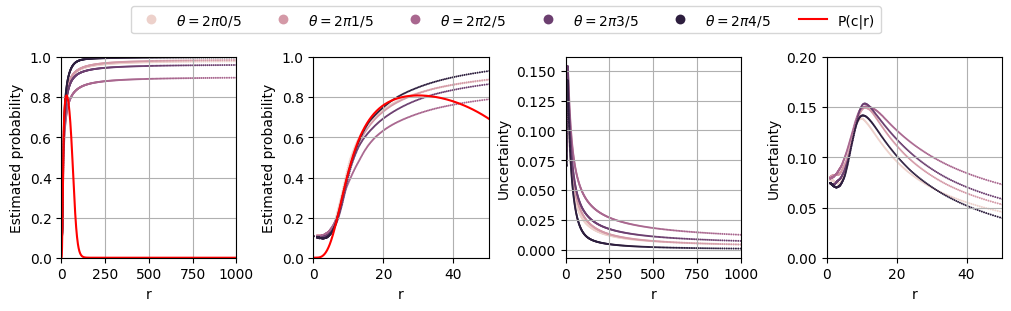

In [8]:
def plot_large_grid(df, prob_key, err_key):

    fig, axs = plt.subplots(nrows = 1, ncols = 4, figsize = (10, 3), layout="constrained")

    #Plot estimated probabilities
    sn.scatterplot(df, x="r", y=prob_key, hue="n_a1", ax=axs[0], s=2, linewidth=0, alpha=1, legend="full")
    sn.lineplot(df[df["a1"]==0.0], x="r", y="p_c1_given_r", ax=axs[0], label="P(c|r)", color="red")
    axs[0].set_ylabel("Estimated probability", size=10)
    axs[0].set_xlim(0, large_grid_rmax)
    axs[0].set_ylim(0, 1)

    sn.scatterplot(df, x="r", y=prob_key, hue="n_a1", ax=axs[1], s=2, alpha=1, linewidth=0, legend=False)
    sn.lineplot(df[df["a1"]==0.0], x="r", y="p_c1_given_r", ax=axs[1], legend=False, color="red")
    axs[1].set_ylabel("Estimated probability", size=10)
    axs[1].set_xlim(0, grid_rmax)
    axs[1].set_ylim(0, 1)

    #Plot uncertainties
    sn.scatterplot(df, x="r", y=err_key, hue="n_a1", ax=axs[2], s=2, linewidth=0, alpha=1, legend=False)
    axs[2].set_ylabel("Uncertainty", size=10)
    #axs[2].set_ylim(0, 1)
    axs[2].set_xlim(0, large_grid_rmax)

    sn.scatterplot(df, x="r", y=err_key, hue="n_a1", ax=axs[3], s=2, linewidth=0, alpha=1, legend=False)
    axs[3].set_ylabel("Uncertainty", size=10)
    axs[3].set_xlim(0, grid_rmax)
    axs[3].set_ylim(0, 0.2)

    for ax in axs:
        ax.grid(True)

    handles, labels = axs[0].get_legend_handles_labels()
    len_labels = len(labels) - 1
    for i in range(len_labels):
        labels[i] = rf"$\theta = 2\pi${i}/{len_labels}"
    axs[0].get_legend().remove()
    fig.suptitle("    ", fontsize=26)
    fig.legend(handles, labels, loc='upper center', ncol=len_labels+1, labelspacing=0.1, fontsize=10, markerscale=5)

for i in range(len(n_data)):
    plot_large_grid(large_grid_dfs[i], "Est_prob_blue", "Uncertainty")

In [9]:
test_dfs[0]

class          r        a1         x1         x2  p_c0  p_r_given_c0  \
0         0   4.289633  4.245334  -1.931443  -3.830206   0.5      0.072759   
1         0  17.423602  4.247328  -7.814084 -15.573118   0.5      0.021370   
2         1  17.497000  5.495961  12.349632 -12.394821   0.5      0.021147   
3         1  18.340633  0.669942  14.376446  11.388443   0.5      0.018725   
4         1  17.734816  4.248409  -7.936523 -15.859865   0.5      0.020439   
...     ...        ...       ...        ...        ...   ...           ...   
9995      0   3.222224  2.580172  -2.727611   1.715478   0.5      0.067661   
9996      1  16.659278  0.202857  16.317679   3.356321   0.5      0.023807   
9997      1  18.598490  0.671747  14.557703  11.574849   0.5      0.018034   
9998      0   6.518083  6.116791   6.428058  -1.079573   0.5      0.070799   
9999      1  12.773676  1.753323  -2.318617  12.561481   0.5      0.039707   

      p_c0_given_r  p_c1  p_r_given_c1  p_c1_given_r       p_r  Prediction  \
0         0.948213   0.5      0.003974      0.051787  0.038366           0   
1         0.279314   0.5      0.055139      0.720686  0.038254           0   
2         0.277902   0.5      0.054949      0.722098  0.038048           1   
3         0.262935   0.5      0.052491      0.737065  0.035608           1   
4         0.273450   0.5      0.054306      0.726550  0.037372           0   
...            ...   ...           ...           ...       ...         ...   
9995      0.980346   0.5      0.001356      0.019654  0.034509           0   
9996      0.295183   0.5      0.056845      0.704817  0.040326           1   
9997      0.258796   0.5      0.051650      0.741204  0.034842           1   
9998      0.822159   0.5      0.015314      0.177841  0.043057           0   
9999      0.419190   0.5      0.055016      0.580810  0.047362           1   

      Est_prob_blue  Uncertainty  Std_prob_blue   Beliefs  
0          0.165421     0.119424       0.059712  0.050212  
1          0.477835     0.160512       0.080256  0.362686  
2          0.573663     0.092049       0.046025  0.537776  
3          0.709715     0.107030       0.053515  0.650837  
4          0.488302     0.159932       0.079966  0.374259  
...             ...          ...            ...       ...  
9995       0.170225     0.122565       0.061282  0.051216  
9996       0.596761     0.102454       0.051227  0.551150  
9997       0.714256     0.105936       0.052968  0.656071  
9998       0.290799     0.116767       0.058383  0.220008  
9999       0.585407     0.179265       0.089633  0.432792  

[10000 rows x 17 columns]

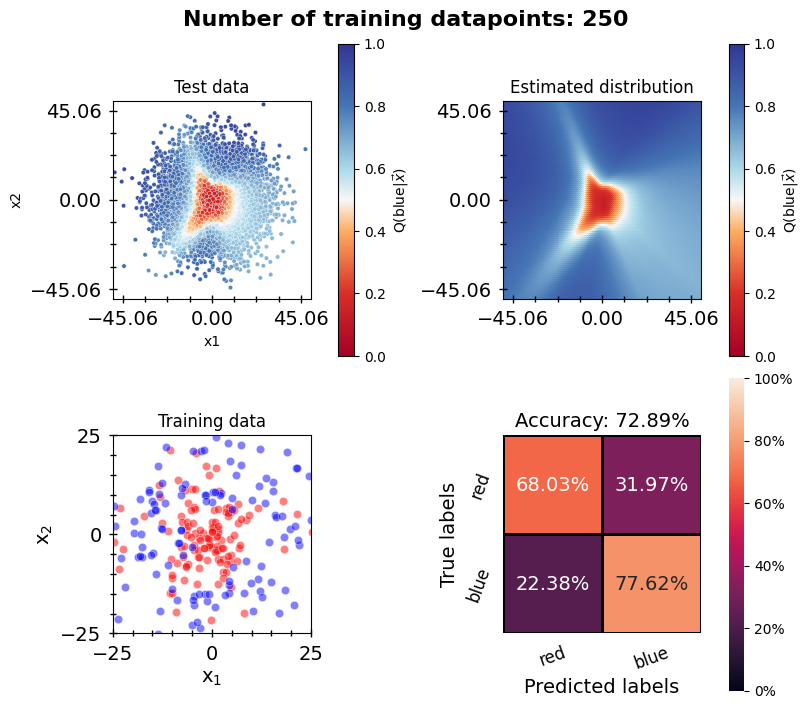

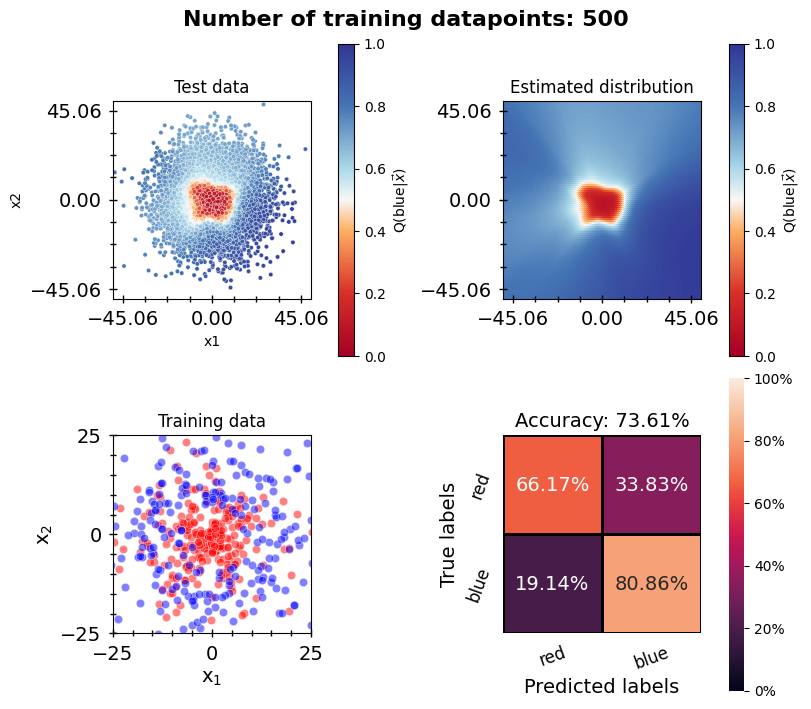

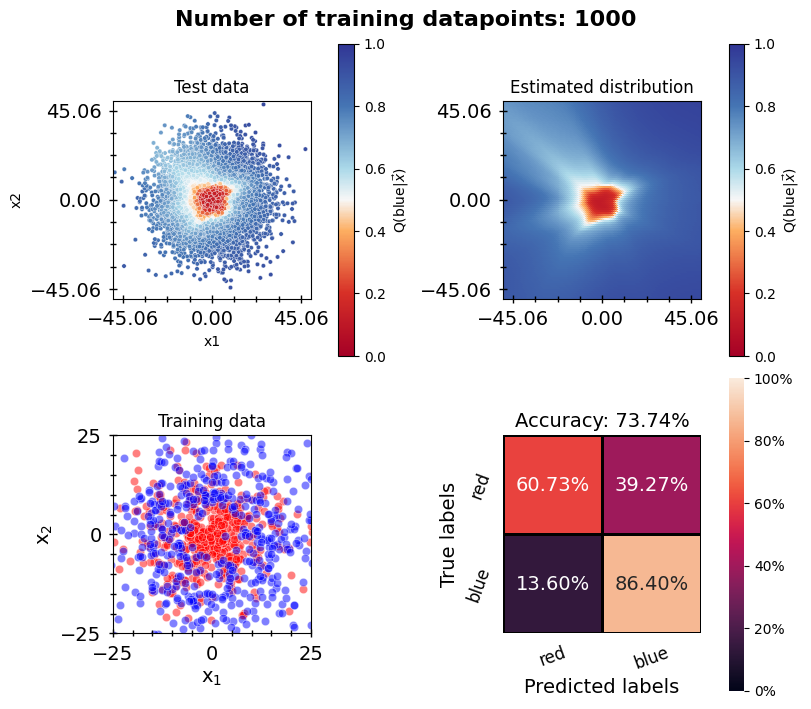

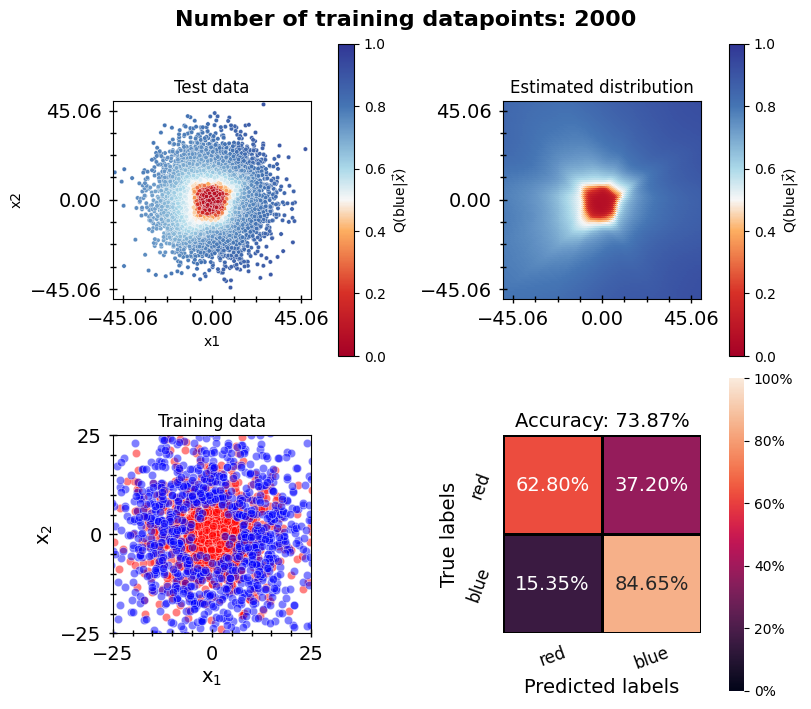

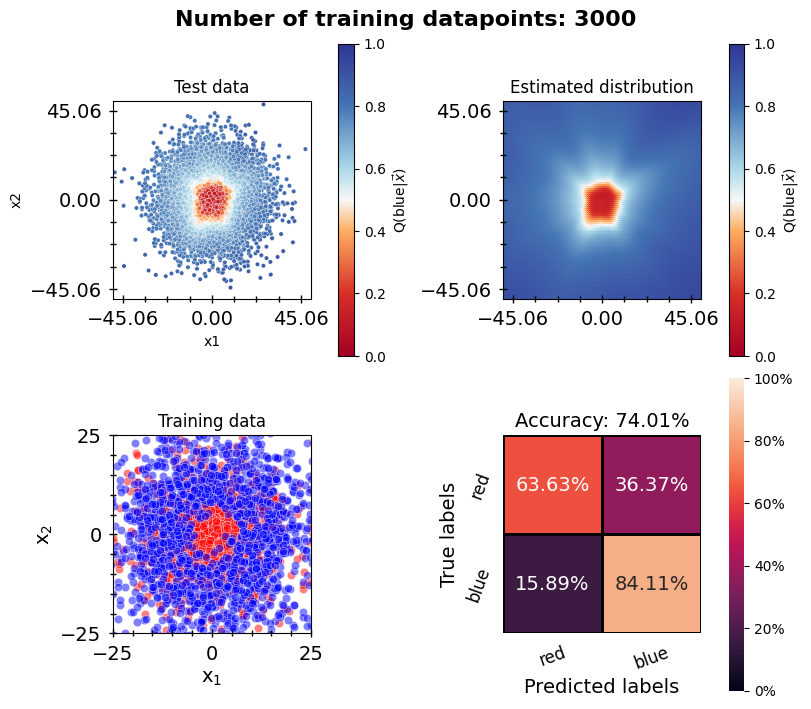

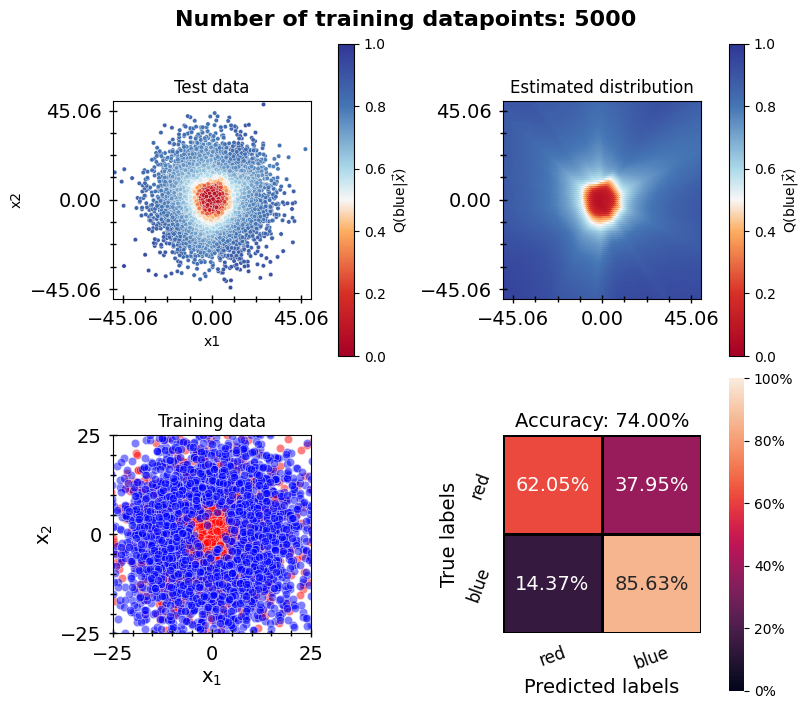

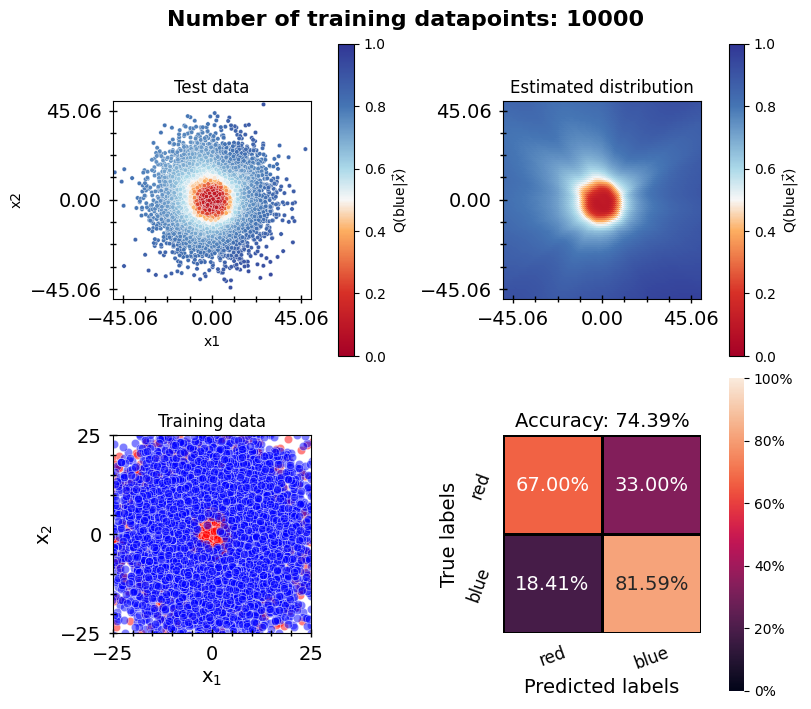

In [10]:
for i in range(len(n_data)):
    # Plot
    fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize = (8, 7), layout="constrained")

    axs[0][0] = plot_results(test_dfs[i], "Est_prob_blue", axs[0][0], "Test data", error_key="Std_prob_blue", rmax=grid_rmax)
    axs[0][1] = plot_results(grid_dfs[i], "Est_prob_blue", axs[0][1], "Estimated distribution", grid=True, rmax=grid_rmax)
    axs[1][1] = plot_conf_matrix(test_dfs[i], "class", "Prediction", ["red", "blue"], axs[1][1])
    axs[1][0] = plot_data(train_data[0:n_data[i]], axs[1][0], "Training data")


    cmap = red_blue_cmap()
    hue_norm = mpl.colors.Normalize(vmin=0, vmax=1, clip=False)
    fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm, cmap=cmap), label=r"Q(blue|$\vec{x}$)", ax=axs[0][0])
    fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm, cmap=cmap), label=r"Q(blue|$\vec{x}$)", ax=axs[0][1])

    fig.suptitle(f"Number of training datapoints: {n_data[i]}", size=16, fontweight="bold")


<Axes: xlabel='r', ylabel='Count'>

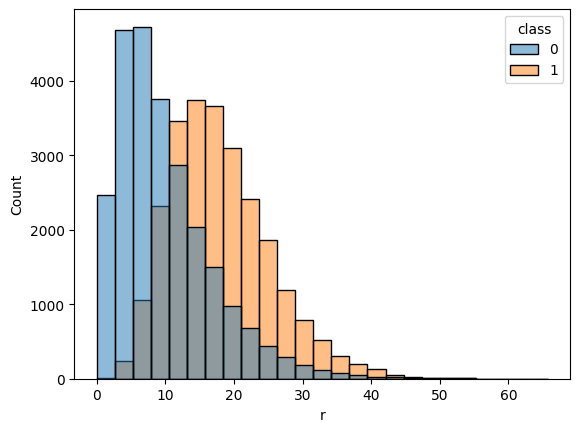

In [11]:
sn.histplot(train_data, x="r", hue="class", bins=25)
#plt.xlim(25, 30)
#plt.ylim(0, 30)

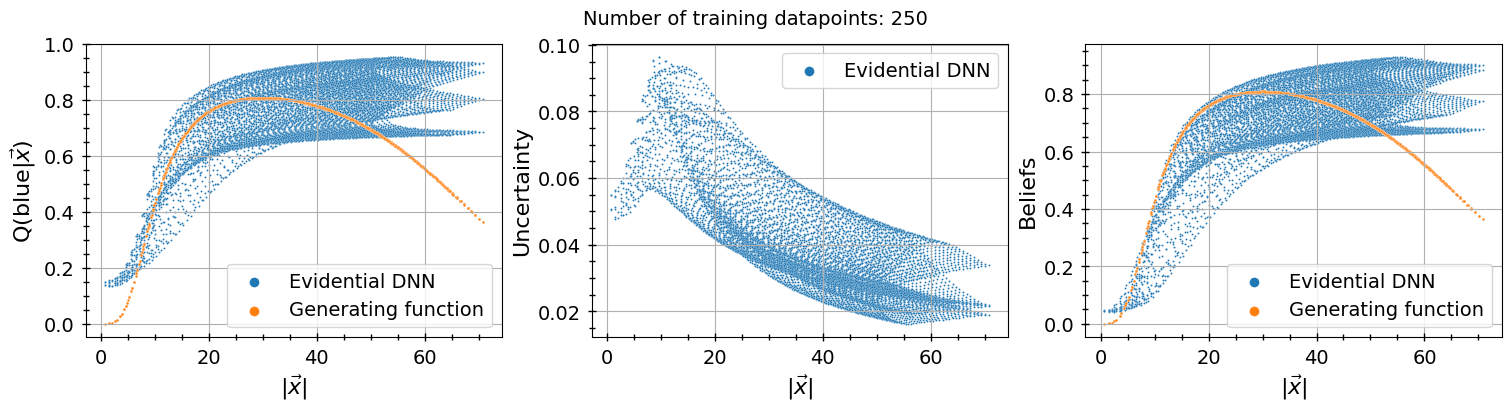

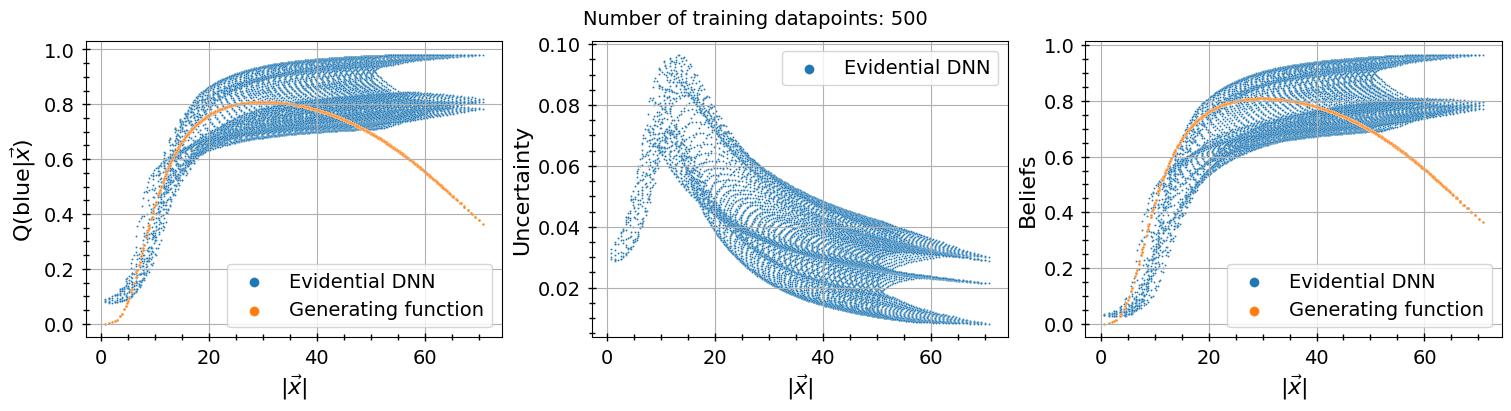

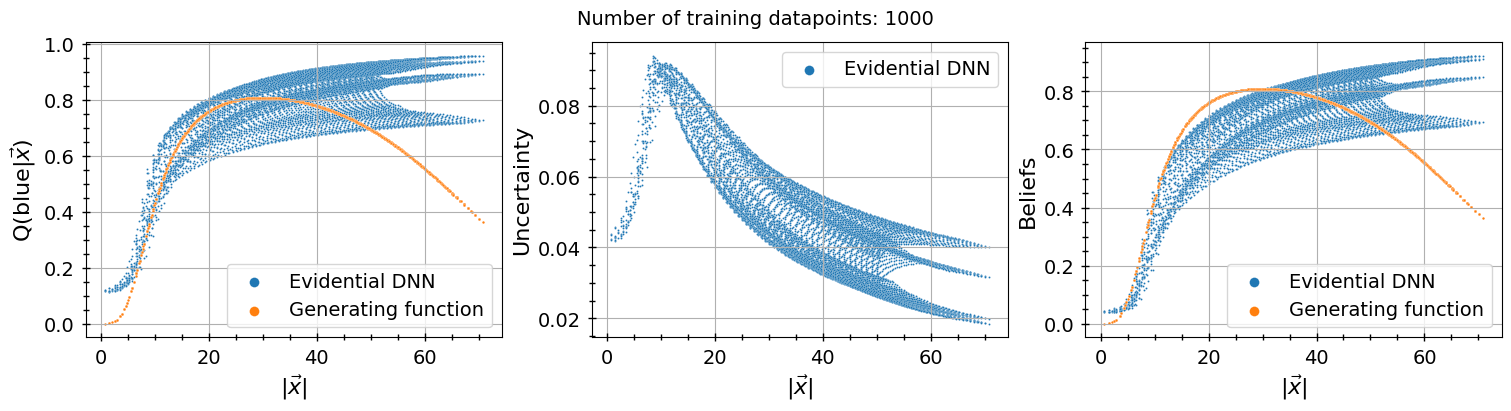

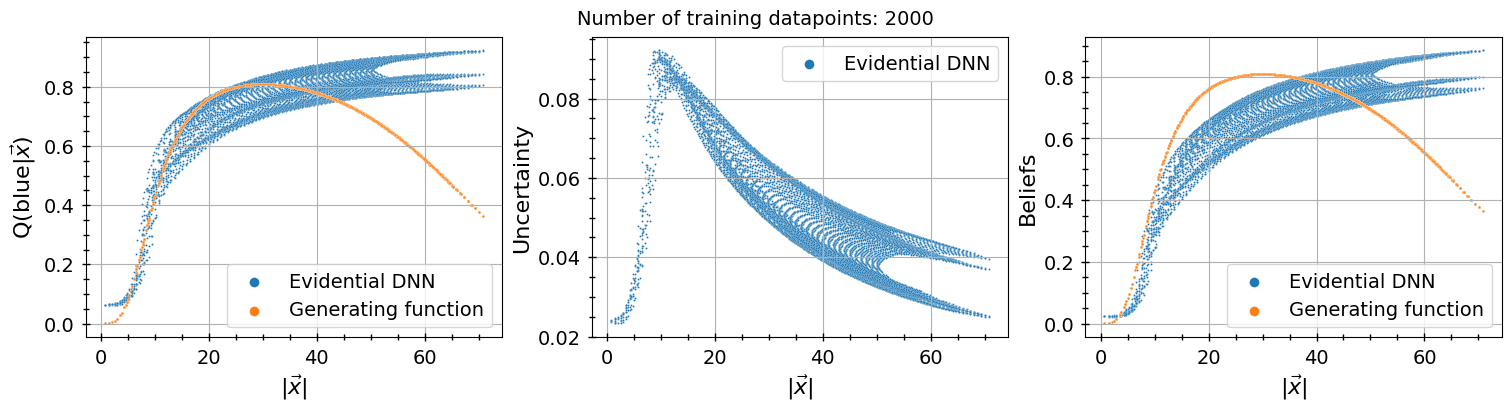

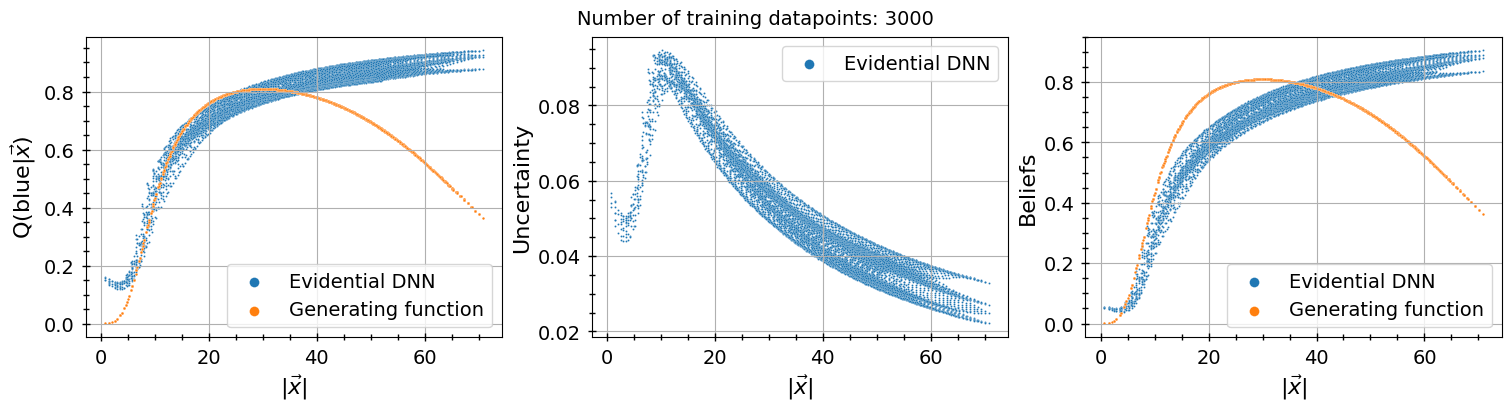

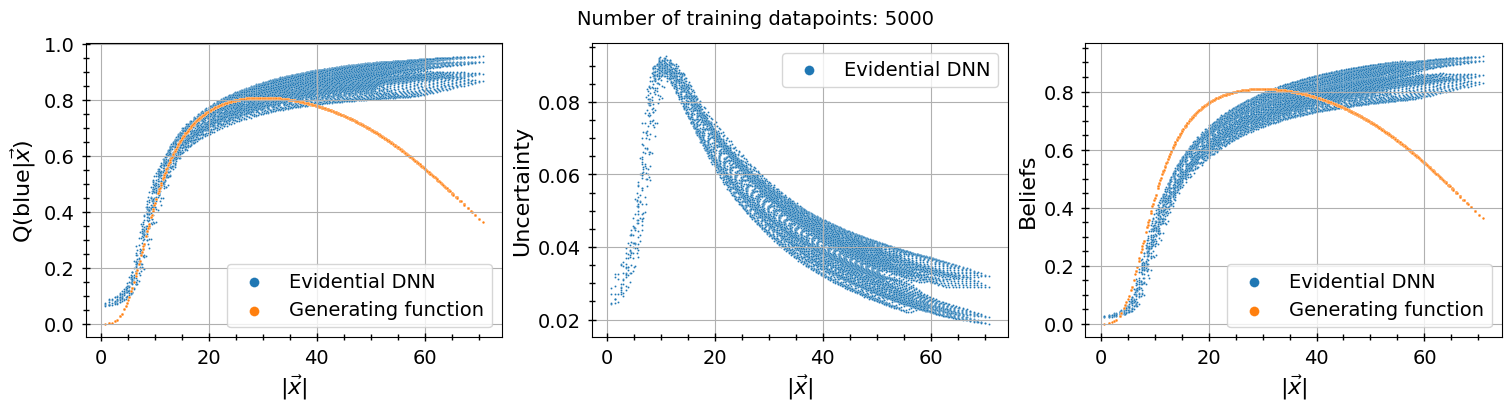

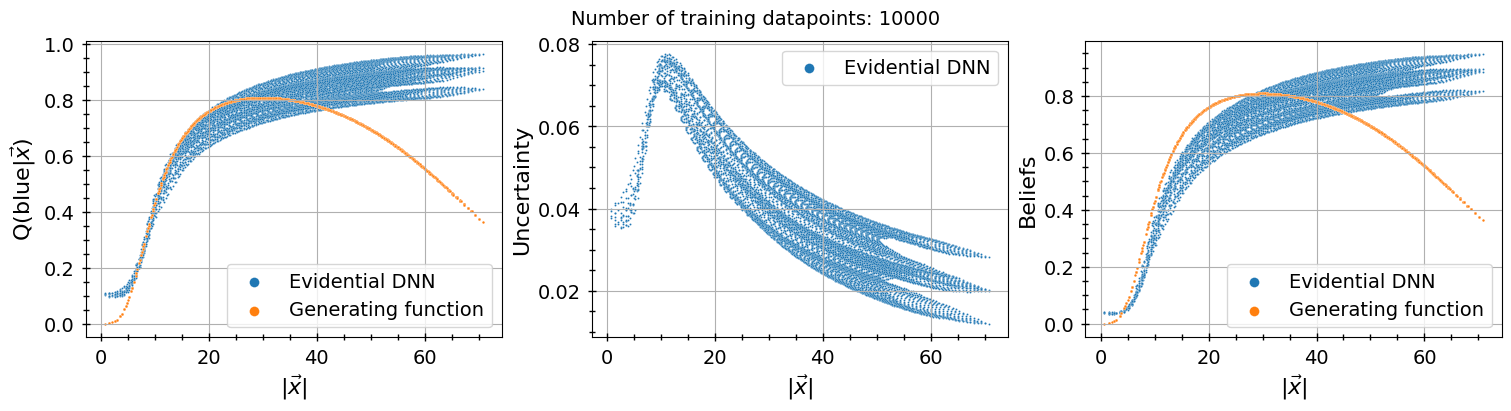

In [12]:
for i in range(len(n_data)):
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize= (5*3, 4), layout="constrained")

    sn.scatterplot(grid_dfs[i], x="r", y="Est_prob_blue", s=2, ax = axs[0], label ="Evidential DNN")
    sn.scatterplot(grid_dfs[i], x="r", y="p_c1_given_r", s=2, ax = axs[0], label="Generating function")
    axs[0].set_ylabel(r"Q(blue|$\vec{x}$)", fontsize=16)

    sn.scatterplot(grid_dfs[i], x="r", y="Std_prob_blue", s=2, ax = axs[1], label ="Evidential DNN")
    axs[1].set_ylabel(r"Uncertainty", fontsize=16)

    sn.scatterplot(grid_dfs[i], x="r", y="Beliefs", s=2, ax = axs[2], label ="Evidential DNN")
    sn.scatterplot(grid_dfs[i], x="r", y="p_c1_given_r", s=2, ax = axs[2], label="Generating function")
    axs[2].set_ylabel(r"Beliefs", fontsize=16)

    fig.suptitle(f"Number of training datapoints: {n_data[i]}", fontsize=14)
    for ax in axs:
        ax.tick_params(which="both", direction="inout", bottom=True, left=True, labelsize=14, pad=5, length=4, width=1)
        ax.tick_params(which="major", length=6)
        ax.minorticks_on()
        ax.grid()
        ax.set_xlabel(r"$|\vec{x}|$", fontsize=16)
        ax.legend(markerscale=5, fontsize=14)

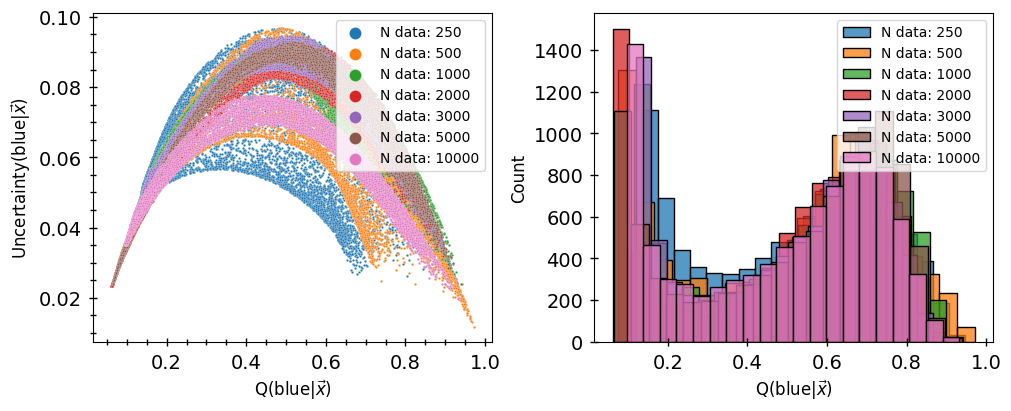

In [13]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize= (10, 4), layout="constrained")
for i in range(len(n_data)):
    sn.scatterplot(test_dfs[i], x="Est_prob_blue", y="Std_prob_blue", s=3, label=f"N data: {n_data[i]}", ax = axs[0])
    axs[0].legend(markerscale=5, fontsize=10, loc="upper right")
    axs[0].set_ylabel(r"Uncertainty(blue|$\vec{x}$)", fontsize=12)
    axs[0].set_xlabel(r"Q(blue|$\vec{x}$)", fontsize=12)
    #axs[0].set_ylim(0, 0.25)
    sn.histplot(test_dfs[i], x="Est_prob_blue", label=f"N data: {n_data[i]}", ax = axs[1], bins=20, edgecolor="black", linewidth=1)
    axs[1].legend(markerscale=5, fontsize=10, loc="upper right")
    axs[1].set_ylabel("Count", fontsize=12)
    axs[1].set_xlabel(r"Q(blue|$\vec{x}$)", fontsize=12)
    for ax in axs:
        ax.tick_params(which="both", direction="inout", bottom=True, left=True, labelsize=14, pad=5, length=4, width=1)
        ax.tick_params(which="major", length=6)
    axs[0].minorticks_on()
    #fig.suptitle(f"Number of training datapoints: {n_data[i]}", size=16, fontweight="bold")

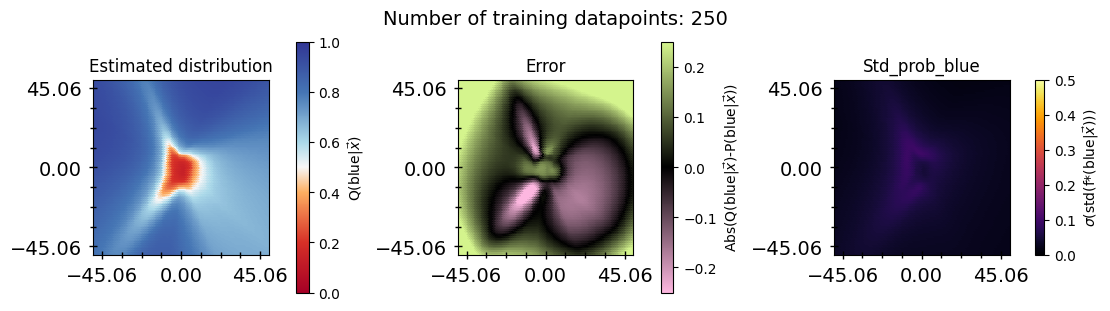

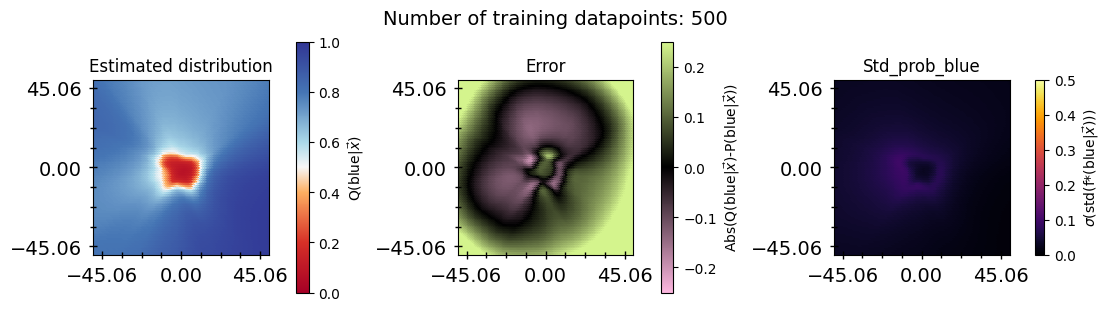

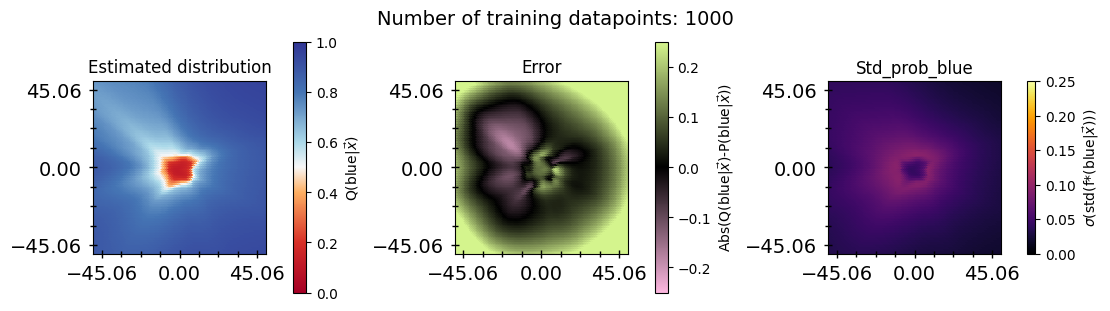

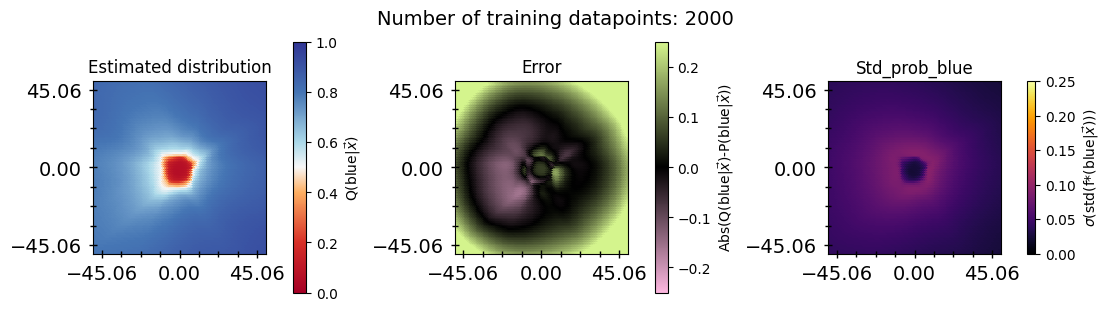

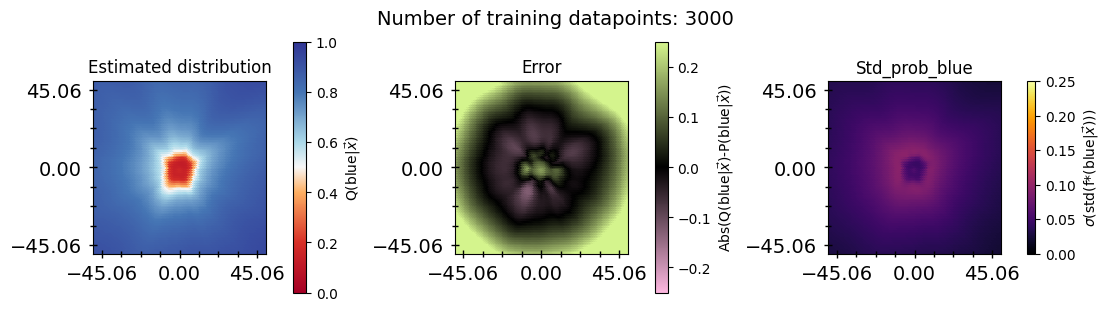

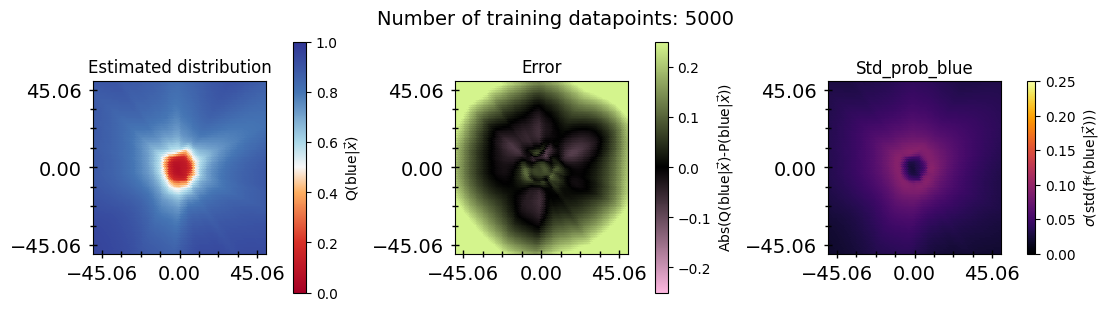

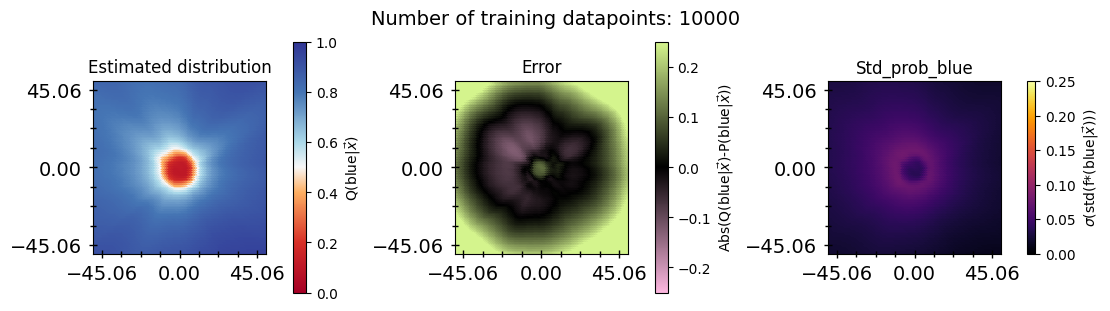

In [14]:
for i in range(len(n_data)):
    fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize = (11,3), layout="constrained")

    axs[0] = plot_results(grid_dfs[i], "Est_prob_blue", axs[0], "Estimated distribution", grid=True, rmax=grid_rmax)
    hue_norm = mpl.colors.Normalize(vmin=0, vmax=1, clip=False)
    fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm, cmap=red_blue_cmap()), label=r"Q(blue|$\vec{x}$)", ax=axs[0])

    axs[1] = plot_diff(grid_dfs[i], grid_dfs[0], "Est_prob_blue", "p_c1_given_r", axs[1], r"Error", max_val=0.25, rmax=grid_rmax)
    hue_norm = mpl.colors.Normalize(vmin=-0.25, vmax=0.25, clip=False)
    fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm, cmap=pink_black_green_cmap()), label=r"Abs(Q(blue|$\vec{x}$)-P(blue|$\vec{x}$))", ax=axs[1])

    axs[2] = plot_std(grid_dfs[i], "Std_prob_blue", axs[2], "Std_prob_blue", grid=True, max_val=max_err_val[i], rmax=grid_rmax)
    hue_norm = mpl.colors.Normalize(vmin=0, vmax=max_err_val[i], clip=False)
    fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm, cmap="inferno"),  fraction=0.050, pad=0.04,
                    label=r"$\sigma$(std(f*(blue|$\vec{x}$)))", ax=axs[2])

    fig.suptitle(f"Number of training datapoints: {n_data[i]}", fontsize=14)


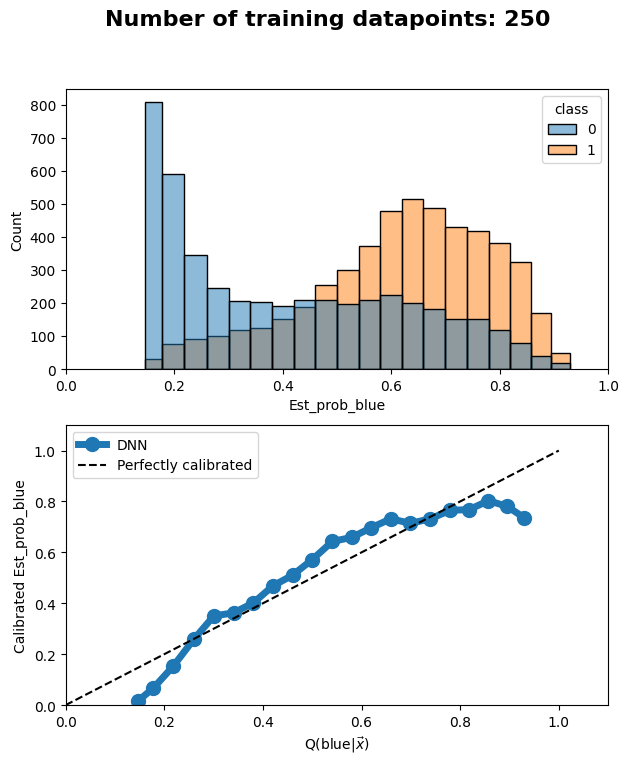

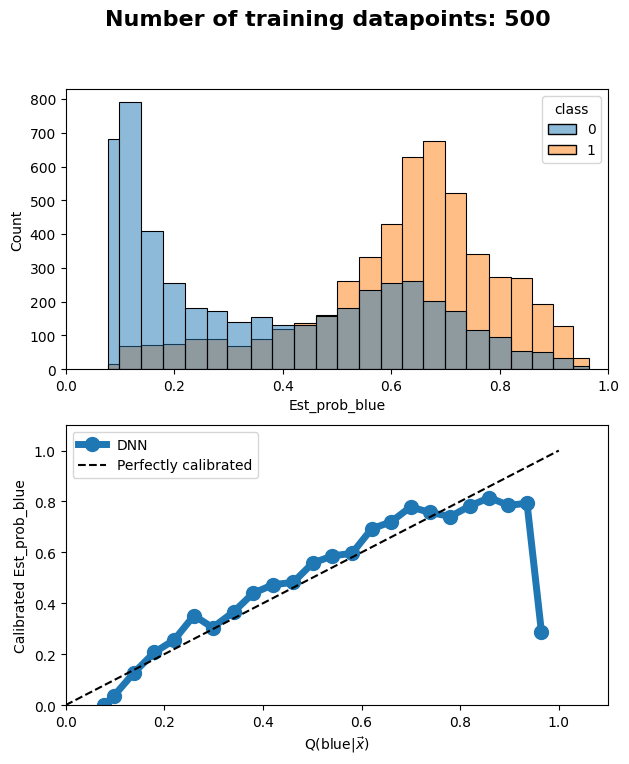

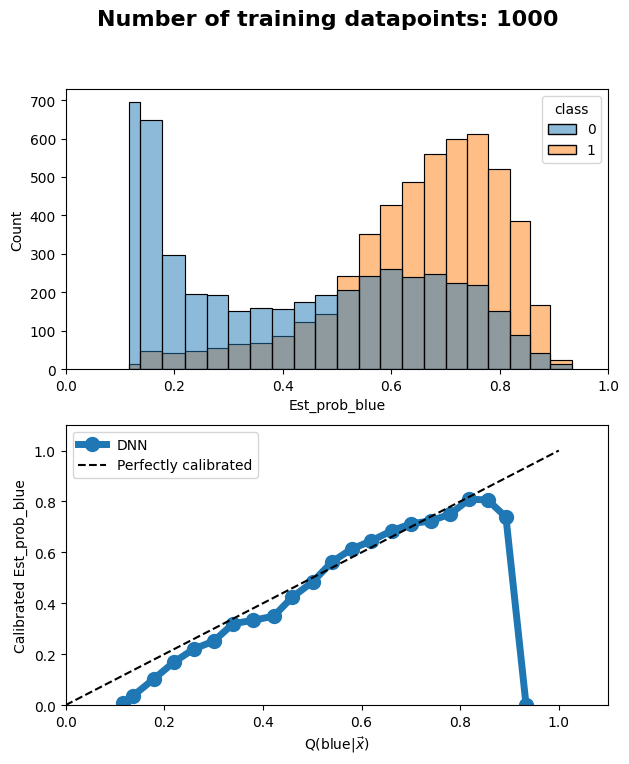

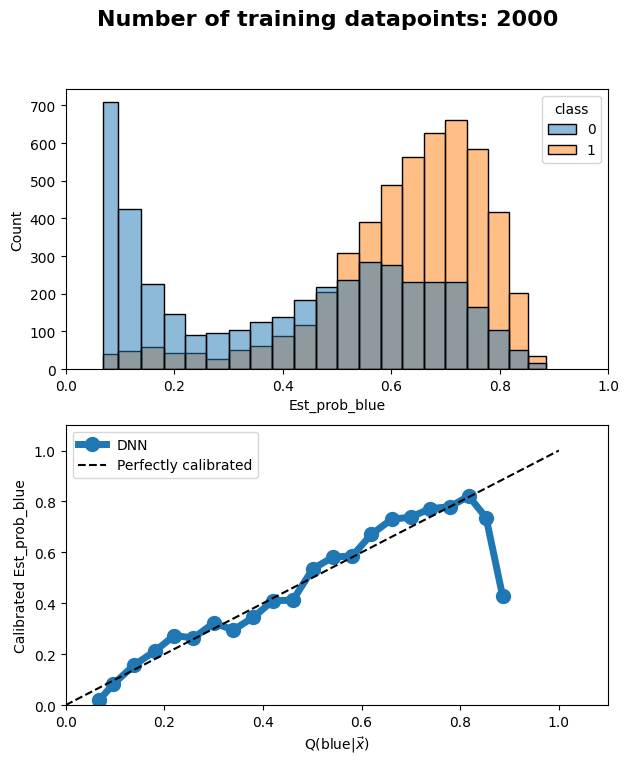

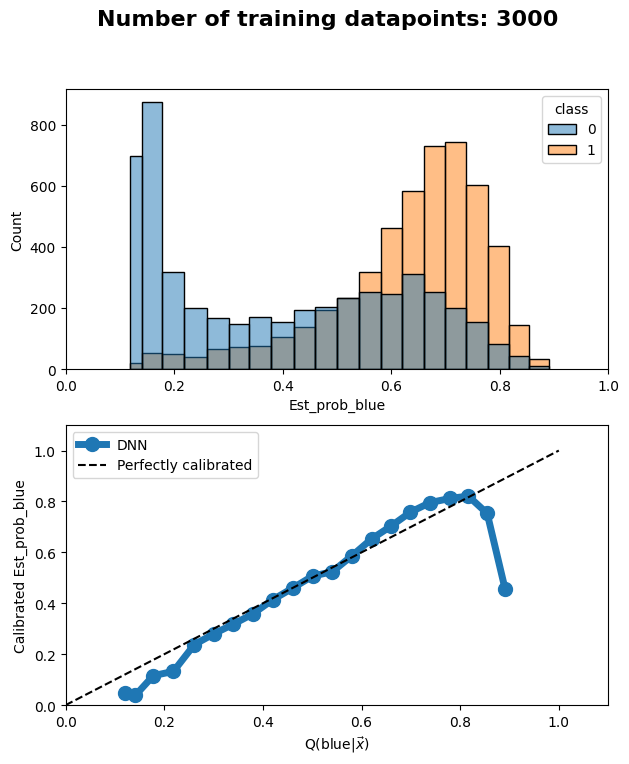

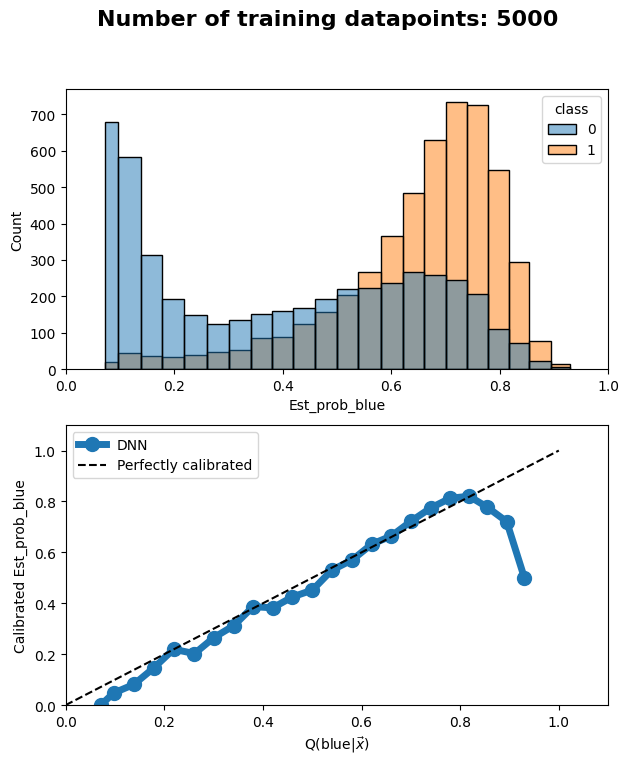

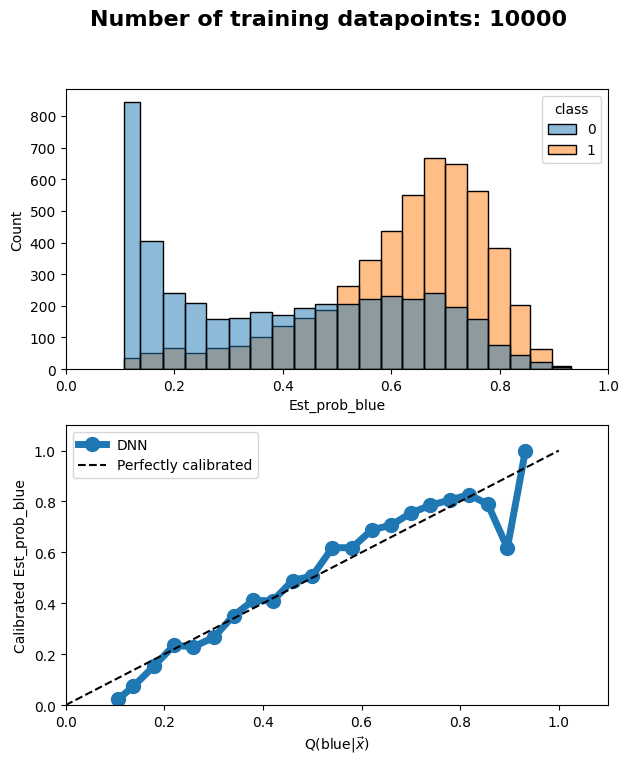

In [15]:
for i in range(len(n_data)):

    prob_cal, prob_pred = calibration_curve(test_dfs[i]["class"], test_dfs[i]["Est_prob_blue"], n_bins=25, strategy="uniform")
    pred_bins=list(prob_pred)

    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(7, 8))
    sn.histplot(test_dfs[i], x="Est_prob_blue", hue="class", ax=ax[0], stat="count", bins=pred_bins)
    ax[0].set_xlim(0,1)
    ax[1].plot(prob_pred, prob_cal, linewidth=5, markersize=10, marker="o", label ="DNN")
    ax[1].set_xlim(0,1.1)
    ax[1].set_ylim(0,1.1)
    x = np.linspace(0, 1, 10)
    ax[1].plot(x, x, color="black", linestyle="--", label="Perfectly calibrated")
    ax[1].set_xlabel(r"Q(blue|$\vec{x}$)")
    ax[1].set_ylabel("Calibrated Est_prob_blue")
    ax[1].legend()
    fig.suptitle(f"Number of training datapoints: {n_data[i]}", size=16, fontweight="bold")